# Process Input Scenes Using OS5_ADI_3.2 psfs

In [2]:
from importlib import reload

import hlc_processing
reload(hlc_processing)

import disk_processing
reload(disk_processing)

import astropy.io.fits as fits
import astropy.units as u
import os
import numpy as np
import poppy.utils as utils
import poppy
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from matplotlib.colors import LogNorm
import glob
import time
from utils import displ_scale  
from scipy.interpolate import RegularGridInterpolator
import traceback

plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})

my_home_dir = os.getcwd() # gets the current working directory
print(my_home_dir)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection


In [3]:
thresh = 1e32
localzodi = 5.2e-11 #Jy/pix (22 mags/sq as)

det_oversample = 4
resel = (550*u.nm/(2.4*u.m)*u.radian).to(u.arcsec)
out_pixscale = (resel/det_oversample).value

In [4]:
dmodels = glob.glob(my_home_dir+"\DebesModels\*\**.fits",recursive = True) # collect the debes_models
#for i,debes_model in enumerate(debes_models): print(i,debes_model)


In [5]:
# Read in the file of PSFs and the file containing the offset values which are in units of Lambda/D at first
psfs_file = my_home_dir+"\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs.fits"
offsets_file = my_home_dir+"\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs_offsets.fits"

hlc_large_range = fits.open(psfs_file)
hlc_large_offsets = fits.open(offsets_file)

# Get the header of the psfs to be able to refer to information directly from the files
fits_header = fits.getheader(psfs_file)

In [6]:
# Trim the PSFs in hlc_large_range to make the data more compatible
trimmed_psfs = hlc_large_range[0].data[:,8:-9,8:-9] # reshapes the data for each psf to make the 200x200 instead of 217x217 
print(trimmed_psfs.shape)
hlcpsfs = np.moveaxis(trimmed_psfs,0,-1)
print(hlcpsfs.shape)

# write the trimmed PSFs to a new fits file and view the fits file to make sure everything worked properly
fits.writeto("OS5_trimmed_cube.fits",trimmed_psfs,overwrite = True)
fits.writeto("OS5_trimmed_moved_cube.fits",hlcpsfs.T,overwrite = True)


(18, 200, 200)
(200, 200, 18)


In [7]:
fits_header = fits.getheader(psfs_file)
fits_header["PIXELSCL"] = fits_header["PIX_AS"]
for i, val in enumerate(fits_header,0):
    print(i,val)

0 SIMPLE
1 BITPIX
2 NAXIS
3 NAXIS1
4 NAXIS2
5 NAXIS3
6 DATE
7 LAM_C
8 MINLAM
9 MAXLAM
10 PIX_AS
11 PIX_LD
12 PIXELSCL


In [8]:
# Convert the Lambda/D offset values to milliarcseconds
lambda_c = fits_header["LAM_C"]*u.nm
lambda_D = lambda_c/(2.37*u.m) # define lambda/D
xmas = np.array(list(hlc_large_offsets[0].data[:]*lambda_D.decompose().value*206265e3))*u.milliarcsecond

# display the xmas values to make sure they are correct
xmas

<Quantity [  0.      ,  43.08066 , 100.521545, 114.881775, 129.24199 ,
           157.96242 , 172.32265 , 186.68288 , 215.4033  , 229.76355 ,
           258.48398 , 287.2044  , 344.6453  , 387.72598 , 402.08618 ,
           416.4464  , 430.8066  , 445.16684 ] marcsec>

In [9]:
n = 200

x = range(n)
y = range(n)
z = xmas

my_interpolating_function = RegularGridInterpolator((x, y, z), 
                                                    hlcpsfs,
                                                    bounds_error = False,
                                                    method = "linear", #~2x faster than linear
                                                    fill_value = 0)

my_interpolating_function_n = RegularGridInterpolator((x, y, z), 
                                                      hlcpsfs,
                                                      bounds_error = False,
                                                      method = "nearest", #~2x faster than linear
                                                      fill_value = 0)

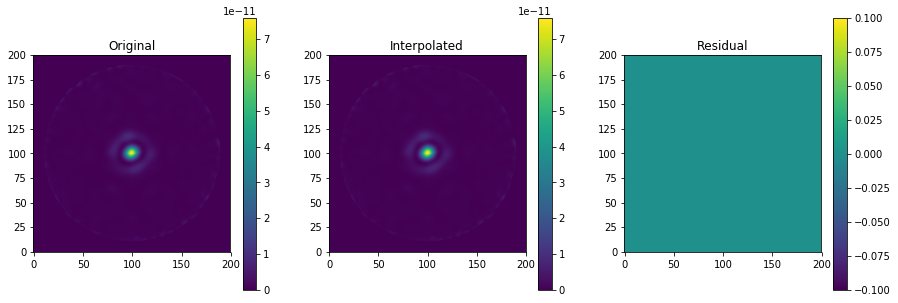

In [10]:
# Now do the interpolation
n = 200 # the x,y grid can be interpolated interpolated over a 200x200 grid

x = range(n)
y = range(n)

grid = np.meshgrid(x,y)
pts = np.vstack([np.vstack([grid[0].flatten(),grid[1].flatten()]),0*np.ones(len(grid[0].flatten()))]).T
interpped = my_interpolating_function(pts).reshape(n,n).T

# Now display everything
plt.figure(figsize=[15,5])

# Plot the original PSF
plt.subplot(131)
plt.title("Original")
plt.imshow(hlcpsfs[:,:,0])
plt.colorbar()
# Plot the interpolated PSF
plt.subplot(132)
plt.title("Interpolated")
plt.imshow(interpped)
plt.colorbar()
# Plot the inerpolated - original PSF
plt.subplot(133)
plt.title("Residual")
plt.imshow(interpped-hlcpsfs[:,:,0])
plt.colorbar()

plt.show()

In [11]:
hlc_processing.USE_OPENCV
# if true, then cv2 was imported successfully
# if false, cv2 cannot be imported and instead scipy.ndimage is imported

False

0.1
0.00476662 arcsec


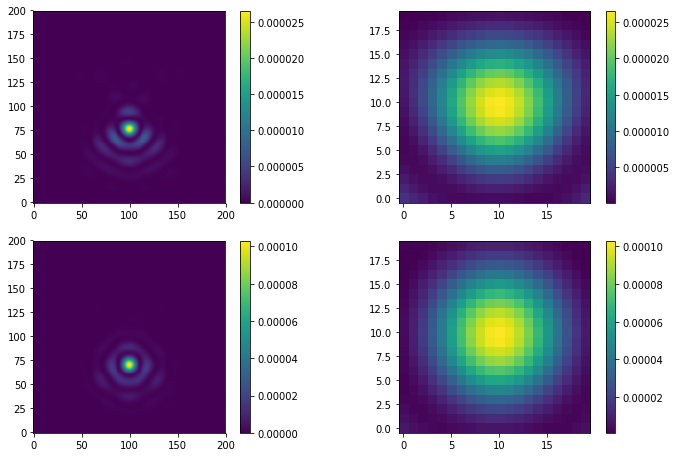

In [19]:
reload(hlc_processing)

HLC_plate_scale_LD = fits_header["PIX_LD"] # arcsec/pixel of HLC PSFs
print(HLC_plate_scale_LD)

HLC_plate_scale = fits_header["PIX_AS"]*u.arcsec # arcsec/pixel of HLC PSFs
print(HLC_plate_scale)

HLC_plate_scale_AS = HLC_plate_scale

mask_radius = 0.7/fits_header["PIX_AS"]

plt.figure(figsize=[12,12])

planet1 = hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale,
                                                mask_radius = None)

plt.subplot(321)
plt.imshow(planet1[:,:])
plt.colorbar()

i,j = np.unravel_index(np.argmax(planet1), np.shape(planet1))
plt.subplot(322)
plt.imshow(planet1[i-10:i+10,j-10:j+10])
plt.colorbar()

planet2 = hlc_processing.closest_monochrome_PSF(120*u.milliarcsecond,0*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale,
                                              mask_radius = mask_radius)

plt.subplot(323)
plt.imshow(planet2[:,:])
plt.colorbar()

i,j = np.unravel_index(np.argmax(planet2), np.shape(planet2))
plt.subplot(324)
plt.imshow(planet2[i-10:i+10,j-10:j+10])
plt.colorbar()

# The prun command is for benchmarking so uncomment it to understand what is going on
# %prun hlc_processing.closest_monochrome_PSF(-300*u.milliarcsecond,200*u.milliarcsecond,my_interpolating_function,xmas,HLC_plate_scale,mask_radius=mask_radius)


# Save the 100mas planet

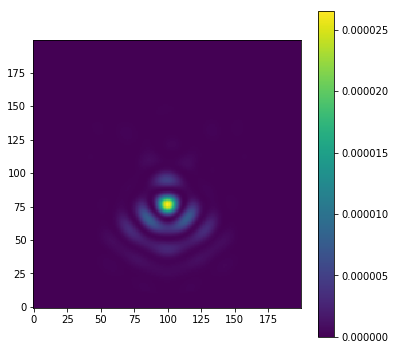

In [13]:
plt.figure(figsize=[6,6])

planet_100mas = hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                                      my_interpolating_function,
                                                      xmas,
                                                      HLC_plate_scale,
                                                      mask_radius = None)

plt.imshow(planet_100mas)
plt.colorbar()

planet_fits_name = my_home_dir + "\planets\\" + "planet_100mas_OS5_3.2.fits"
fits.writeto(planet_fits_name,planet_100mas,overwrite=True)

## Define the paths for the zodi files

In [14]:
reload(hlc_processing)

zodi_path = my_home_dir + "\zodipics\\"
output_path = my_home_dir + "\HLC_output\\"

print(zodi_path)
print(output_path)

# Also define mask and core_mask radii
core_mask_radius = .15*u.arcsec
mask_radius = mask_radius

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\


## zodipic_10pc03mas01alpha.fits

### Output files:
zodipic_10pc03mas01alpha_HLC.fits

zodipic_10pc03mas01alpha_1e+32_input.fits

zodipic_10pc03mas01alpha_coremasked_HLC.fits

zodipic_10pc03mas01alpha_1e+32_coremasked_input.fits

zodipic_10pc03mas01alpha_masked_HLC.fits

zodipic_10pc03mas01alpha_1e+32_masked_input.fits

In [15]:
output_path_1 = output_path + "zodipic_10pc03mas01alpha\\"
print(output_path_1)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_input.fits
1136.0537555217743


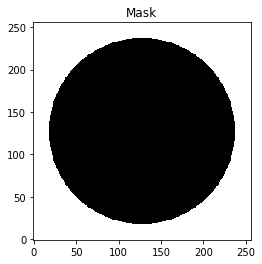

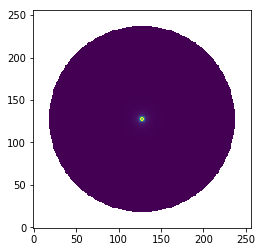

In [33]:
zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_name = output_path_1 + zodi_fname[:-5] + "_HLC.fits"
print(im_name)

zodi_name = output_path_1 + zodi_fname[:-5] + "_input.fits"
print(zodi_name)

start_time = time.time()

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh=thresh)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_name, im, overwrite=True, header=zodi_header) 
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)

print(time.time()-start_time)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_1e+32_coremasked_input.fits
895.7338500022888


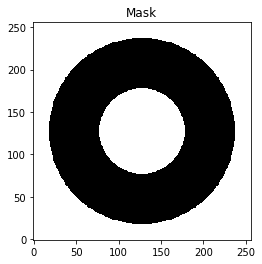

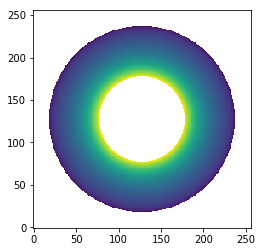

In [30]:
zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_cm_name = output_path_1 + zodi_fname[:-5] + "_coremasked_HLC.fits"
print(im_cm_name)

zodi_cm_name = output_path_1 + zodi_fname[:-5] + "_coremasked_input.fits"
print(zodi_cm_name)

start_time = time.time() # for timing purposes

# Now do it with the core_mask_radius
im_cm,zodi_cm = hlc_processing.fit_to_hlc(zodi_file,
                                        my_interpolating_function,
                                        xmas,
                                        HLC_plate_scale,
                                        display=True,
                                        core_mask_radius=core_mask_radius,
                                        thresh=thresh)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_cm_name, im_cm, overwrite = True, header = zodi_header)
fits.writeto(zodi_cm_name, zodi_cm.filled(fill_value = 0), overwrite=True)

print(time.time()-start_time)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_HLC_nearest.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_input_nearest.fits
534.8744111061096


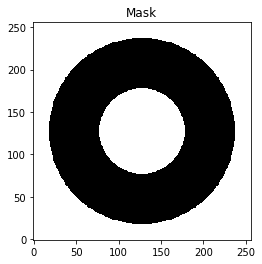

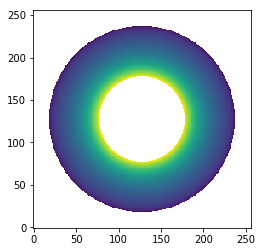

In [32]:
zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_cm_name = output_path_1 + zodi_fname[:-5] + "_coremasked_HLC_nearest.fits"
print(im_cm_name)

zodi_cm_name = output_path_1 + zodi_fname[:-5] + "_coremasked_input_nearest.fits"
print(zodi_cm_name)

start_time = time.time() # for timing purposes

# Now do it with the core_mask_radius
im_cm,zodi_cm = hlc_processing.fit_to_hlc(zodi_file,
                                        my_interpolating_function_n,
                                        xmas,
                                        HLC_plate_scale,
                                        display=True,
                                        core_mask_radius=core_mask_radius,
                                        thresh=thresh)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_cm_name, im_cm, overwrite = True, header = zodi_header)
fits.writeto(zodi_cm_name, zodi_cm.filled(fill_value = 0), overwrite=True)

print(time.time()-start_time)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_masked_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_masked_input.fits
1160.242921113968


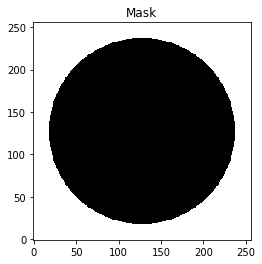

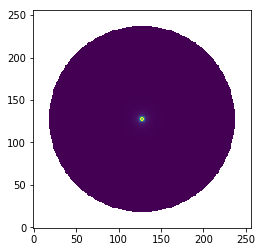

In [17]:
zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_m_name = output_path_1 + zodi_fname[:-5] + "_masked_HLC.fits"
print(im_m_name)

zodi_m_name = output_path_1 + zodi_fname[:-5] + "_masked_input.fits"
print(zodi_m_name)

start_time = time.time() # for timing purposes

# Now do it with the mask_radius
im_m,zodi_m = hlc_processing.fit_to_hlc(zodi_file,
                                        my_interpolating_function,
                                        xmas,
                                        HLC_plate_scale,
                                        display=True,
                                        thresh=thresh,
                                        mask_radius=mask_radius)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_m_name, im_m, overwrite = True, header = zodi_header)
fits.writeto(zodi_m_name, zodi_m.filled(fill_value = 0), overwrite=True)

print(time.time()-start_time)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_HLC_nearest.fits
4.7782177378273577e-14
2.82596085737564e-12
Max location in difference array is [99],[134]
[2.58073385e-12]
[0.01851496]


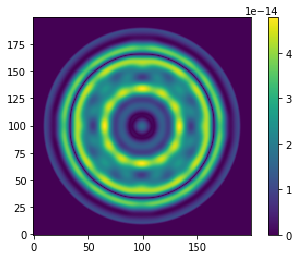

In [34]:
# Now analyze differnce between linear and nearest

zodi_fname = "zodipic_10pc03mas01alpha.fits"

zodi_cm_name = output_path_1 + zodi_fname[:-5] + "_coremasked_HLC.fits"
print(zodi_cm_name)

zodi_cm_name_n = output_path_1 + zodi_fname[:-5] + "_coremasked_HLC_nearest.fits"
print(zodi_cm_name_n)

zodi_cm = fits.getdata(zodi_cm_name)
zodi_cm_n = fits.getdata(zodi_cm_name_n)

# Calculate the diffrence
zodi_diff = np.abs(zodi_cm - zodi_cm_n)

# Find the max difference
print(zodi_diff.max())
print(zodi_cm.max())

max_loc = np.where(zodi_diff == zodi_diff.max())
print("Max location in difference array is {},{}".format(max_loc[0],max_loc[1]))
print(zodi_cm[max_loc[0],max_loc[1]])
print(zodi_diff.max()/zodi_cm[max_loc[0],max_loc[1]])

# Show plot of the difference
plt.imshow(zodi_diff)
plt.colorbar()
plt.show()


## zodipic_03pc03mas01alpha.fits

### Output files:

zodipic_03pc03mas01alpha_HLC.fits

zodipic_03pc03mas01alpha_1e+32_input.fits

zodipic_03pc03mas01alpha_coremasked_HLC.fits

zodipic_03pc03mas01alpha_1e+32_coremasked_input.fits

In [26]:
output_path_2 = output_path + "zodipic_03pc03mas01alpha\\"
print(output_path_2)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_03pc03mas01alpha\


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\zodipic_03pc03mas01alpha_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\zodipic_03pc03mas01alpha_1e+32_input.fits
2192.9948320388794


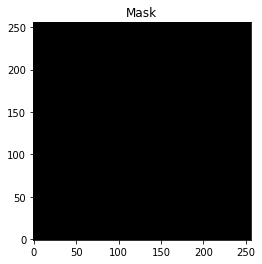

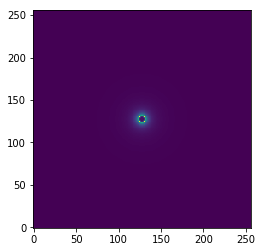

In [12]:
zodi_fname = "zodipic_03pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_name = output_path_2 + zodi_fname[:-5] + "_HLC.fits"
print(im_name)

zodi_name = output_path_2 + zodi_fname[:-5] + "_input.fits"
print(zodi_name)

start_time = time.time()

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh=thresh)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_name, im, overwrite=True, header=zodi_header) 
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)

print(time.time()-start_time)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\zodipic_03pc03mas01alpha_coremasked_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\_1e+32_coremasked_input.fits
1959.1908583641052


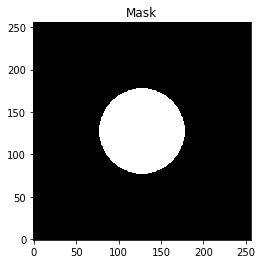

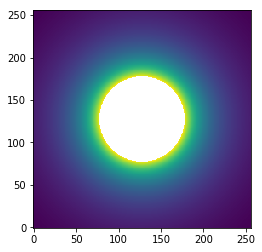

In [13]:
zodi_fname = "zodipic_03pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_cm_name = output_path_2 + zodi_fname[:-5] + "_coremasked_HLC.fits"
print(im_cm_name)

zodi_cm_name = output_path_2 + zodi_fname[:-5] + "_coremasked_input.fits"
print(zodi_cm_name)

start_time = time.time() # for timing purposes

# Now do it with the core_mask_radius
im_cm,zodi_cm = hlc_processing.fit_to_hlc(zodi_file,
                                        my_interpolating_function,
                                        xmas,
                                        HLC_plate_scale,
                                        display=True,
                                        core_mask_radius=core_mask_radius,
                                        thresh=thresh)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_cm_name, im_cm, overwrite = True, header = zodi_header)
fits.writeto(zodi_cm_name, zodi_cm.filled(fill_value = 0), overwrite=True)

print(time.time()-start_time)

## zodipic_03pc03mas.fits

### Output files:

zodipic_03pc03mas_HLC.fits

zodipic_03pc03mas_1e+32_input.fits

zodipic_03pc03mas_coremasked_HLC.fits

zodipic_03pc03mas_1e+32_coremasked_input.fits

In [23]:
output_path_3 = output_path + "zodipic_03pc03mas\\"
print(output_path_3)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_03pc03mas\


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\zodipic_03pc03mas_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\zodipic_03pc03mas_1e+32_input.fits
1186.8480043411255


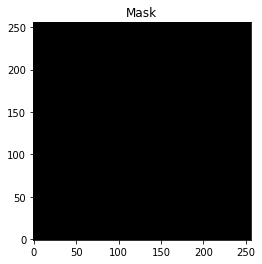

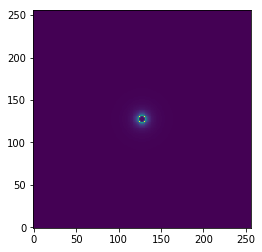

In [28]:
zodi_fname = "zodipic_03pc03mas.fits"
zodi_file = zodi_path + zodi_fname

im_name = output_path_3 + zodi_fname[:-5] + "_HLC.fits"
print(im_name)

zodi_name = output_path_3 + zodi_fname[:-5] + "_input.fits"
print(zodi_name)

start_time = time.time() # for timing purposes

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh = thresh)

zodi_header = fits_header.copy()
zodi_header["thresh"] = thresh

fits.writeto(im_name, im, overwrite=True, header=zodi_header)
fits.writeto(zodi_name, zodi.filled(fill_value=0), overwrite=True)

print(time.time()-start_time)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\zodipic_03pc03mas_coremasked_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs\zodipic_03pc03mas_1e+32_coremasked_input.fits
1044.0682809352875


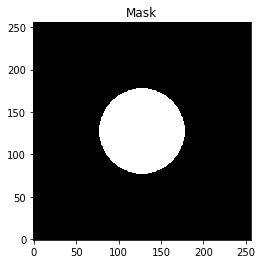

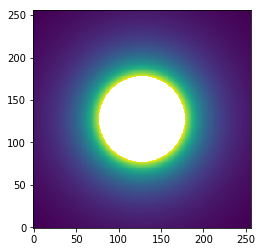

In [29]:
zodi_fname = "zodipic_03pc03mas.fits"
zodi_file = zodi_path + zodi_fname

im_cm_name = output_path_3 + zodi_fname[:-5] + "_coremasked_HLC.fits"
print(im_cm_name)

zodi_cm_name = output_path_3 + zodi_fname[:-5] + "_coremasked_input.fits"
print(zodi_cm_name)

start_time = time.time() # for timing purposes

im_cm,zodi_cm = hlc_processing.fit_to_hlc(zodi_file,
                                          my_interpolating_function,
                                          xmas,
                                          HLC_plate_scale,
                                          display=True,
                                          core_mask_radius=core_mask_radius,
                                          thresh = thresh)

zodi_header = fits_header.copy()
zodi_header["thresh"] = thresh

fits.writeto(im_cm_name, im_cm, overwrite=True, header=zodi_header)
fits.writeto(zodi_cm_name, zodi_cm.filled(fill_value=0), overwrite=True)

print(time.time()-start_time)

## zodipics_10pc03mas.fits

### Output files:

zodipic_10pc03mas_HLC.fits

zodipic_10pc03mas_1e+32_input.fits

zodipic_10pc03mas_coremasked_HLC.fits

zodipic_10pc03mas_1e+32_coremasked_input.fits

In [25]:
output_path_4 = output_path + "zodipic_10pc03mas\\"
print(output_path_4)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_output\zodipic_10pc03mas\


543.1562077999115


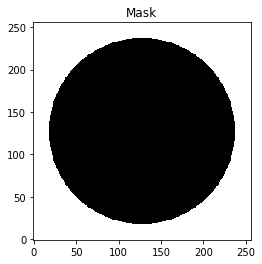

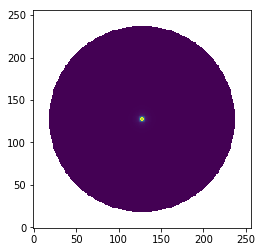

In [25]:
zodi_fname = "zodipic_10pc03mas.fits"
zodi_file = zodi_path + zodi_fname

im_name = output_path_4 + zodi_fname[:-5] + "_HLC.fits"
print(im_name)

zodi_name = output_path_4 + zodi_fname[:-5] + "_input.fits"
print(zodi_name)

start_time = time.time() # for timing purposes

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh=thresh)

fits.writeto(im_name,im,overwrite=True,header=fits.getheader(zodi_file))
fits.writeto(zodi_name,zodi.filled(fill_value = 0),overwrite=True)

print(time.time()-start_time)

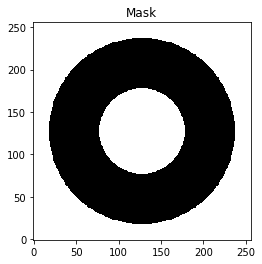

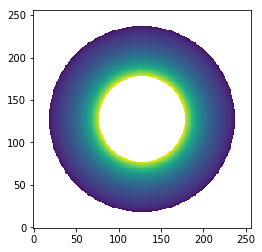

In [26]:
zodi_fname = "zodipic_10pc03mas.fits"
zodi_file = zodi_path + zodi_fname

im_cm_name = output_path_4 + zodi_fname[:-5] + "_coremasked_HLC.fits"
print(im_cm_name)

zodi_cm_name = output_path_4 + zodi_fname[:-5] + "_coremasked_input.fits"
print(zodi_cm_name)

start_time = time.time() # for timing purposes

im_cm,zodi_cm = hlc_processing.fit_to_hlc(zodi_file,
                                          my_interpolating_function,
                                          xmas,
                                          HLC_plate_scale,
                                          display=True,
                                          core_mask_radius=core_mask_radius,
                                          thresh=thresh)

fits.writeto(im_cm_name, im_cm, overwrite = True, header = fits.getheader(zodi_file))
fits.writeto(zodi_cm_name,zodi_cm.filled(fill_value = 0),overwrite=True)


# Plot the Mask and Unmasked PSF for zodipic_10pc03mas01alpha.fits

In [18]:
zodi_fname = "zodipic_10pc03mas01alpha.fits"

zodi_file = zodi_path + zodi_fname

im_name = output_path_1 + zodi_fname[:-5] + "_HLC.fits"
zodi_name = output_path_1 + zodi_fname[:-5] + "_input.fits"
im_cm_name = output_path_1 + zodi_fname[:-5] + "_coremasked_HLC.fits"
zodi_cm_name = output_path_1 + zodi_fname[:-5] + "_coremasked_input.fits"
im_m_name = output_path_1 + zodi_fname[:-5] + "_masked_HLC.fits"
zodi_m_name = output_path_1 + zodi_fname[:-5] + "_masked_input.fits"

zodi = fits.getdata(zodi_file)
im = fits.getdata(im_name)
im_m = fits.getdata(im_m_name)
im_cm = fits.getdata(im_cm_name)
im.shape

(200, 200)

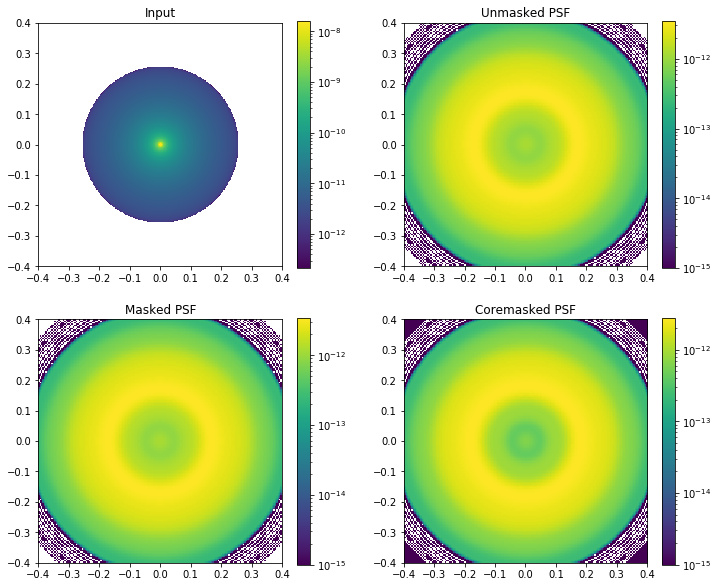

In [19]:
zodi_fits = fits.open(zodi_file)
zodi_pixscale = zodi_fits[0].header["PIXELSCL"]*u.arcsecond

plt.figure(figsize=[12,10])

x_hlc,y_hlc = np.meshgrid(np.arange(-n/2,n/2),np.arange(-n/2,n/2))
x_hlc = (x_hlc+.5).flatten()*HLC_plate_scale
y_hlc = (y_hlc+.5).flatten()*HLC_plate_scale
halfpix_hlc = HLC_plate_scale.to(u.arcsec).value*0.5
halfpix = zodi_pixscale.to(u.arcsec).value*0.5

HLC_extent = ([x_hlc.min().to(u.arcsec).value-halfpix,
               x_hlc.max().to(u.arcsec).value+halfpix, 
               y_hlc.min().to(u.arcsec).value-halfpix,
               y_hlc.max().to(u.arcsec).value+halfpix])

fov = .4

pixnum = np.int(im.shape[0])

x,y = np.meshgrid(np.arange(-pixnum/2,pixnum/2),np.arange(-pixnum/2,pixnum/2))
x = (x+.5).flatten()*zodi_pixscale
y = (y+.5).flatten()*zodi_pixscale

zodi_extent = ([x.min().to(u.arcsec).value-halfpix,
                x.max().to(u.arcsec).value+halfpix, 
                y.min().to(u.arcsec).value-halfpix,
                y.max().to(u.arcsec).value+halfpix])

# The first subplot is the input which is zodi
plt.subplot(221)
plt.title("Input")
plt.imshow(zodi,norm=LogNorm(),extent=zodi_extent)
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.colorbar()

# The second subplot is the Unmasked PSF which is im
plt.subplot(222)
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.title("Unmasked PSF")
plt.imshow(im,interpolation="nearest",norm=LogNorm(),extent=HLC_extent,vmin=1e-15)
plt.colorbar()

# The third subplot is the Masked PSF which is im_m
plt.subplot(223)
plt.title("Masked PSF")
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.imshow(im_m,interpolation="nearest",norm=LogNorm(),extent=HLC_extent,vmin=1e-15)
plt.colorbar()

# The fourth subplot is the Coremasked PSF which is im_cm
plt.subplot(224)
plt.title("Coremasked PSF")
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.imshow(im_cm,interpolation="nearest",norm=LogNorm(),extent=HLC_extent,vmin=1e-15)
plt.colorbar()

#plt.tight_layout()
#plt.savefig(zodi_file[:-5]+"_input_outputs"+str(mask_radius)+"_mask.pdf",bbox_inches="tight")

plt.show()

C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


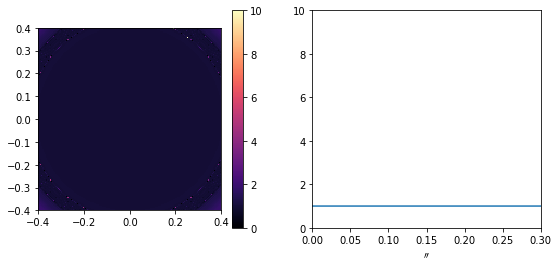

In [15]:
#plot ratio map and radial curve
plt.figure(figsize=[9,4])

plt.subplot(121)
ratio = im/im_m
plt.imshow(ratio, 
           extent=HLC_extent, 
           interpolation="nearest",
           vmin=0, vmax=10,
           cmap=plt.cm.magma)

plt.colorbar()
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])

plt.subplot(122)
plt.plot(x_hlc[0:200],ratio[:,100])
plt.xlim([0,.3])
plt.ylim([0,10])
plt.xlabel("$\prime\prime$")

fits.writeto(im_m_name+"ratio.fits",ratio,zodi_fits[0].header,overwrite=True)
plt.savefig(im_m_name+"ratio.pdf",bbox_inches="tight")
plt.show()


NameError: name 'HLC_extent' is not defined

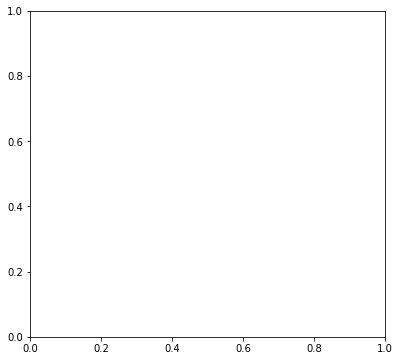

In [16]:
#check that coordinates match expectation.
plt.figure(figsize=[7*2,3*2])

plt.subplot(121)
planet1 = hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale,
                                                mask_radius=mask_radius) 

planet2 = hlc_processing.closest_monochrome_PSF(0*u.milliarcsecond,-40*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale,
                                                mask_radius=mask_radius)

planet3 = hlc_processing.closest_monochrome_PSF(-200*u.milliarcsecond,200*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale,
                                                mask_radius=mask_radius)

plt.imshow(np.array(planet1/planet1.max()+planet2/planet2.max()+planet3/planet3.max()),
           cmap = plt.cm.plasma,
           interpolation="nearest",
           extent=HLC_extent)
plt.grid()
plt.colorbar()

plt.subplot(122)
planet1=hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale)

planet2=hlc_processing.closest_monochrome_PSF(0*u.milliarcsecond,-40*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale)

planet3=hlc_processing.closest_monochrome_PSF(-200*u.milliarcsecond,200*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale)

planets = np.array(planet1 + planet2 + planet3)
planets_norm = np.array(planets/planets.max())
plt.imshow(planets_norm,
           cmap=plt.cm.plasma, 
           interpolation="nearest",
           extent=HLC_extent)
plt.grid()
plt.colorbar()

plt.savefig("normalized_psfs"+str(mask_radius)+"_mask.pdf",bbox_inches="tight")
plt.show()

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas01alpha.fits


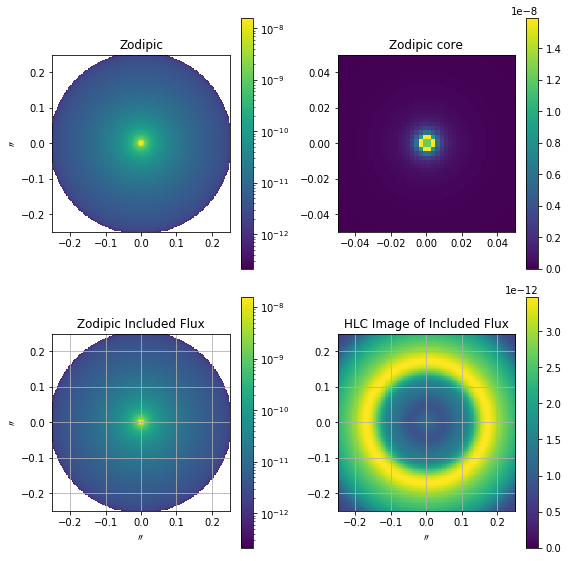

<Figure size 432x288 with 0 Axes>

In [16]:
zodi_file = my_home_dir + "\zodipics\\" + "zodipic_10pc03mas01alpha.fits"
print(zodi_file)

zodi = fits.open(zodi_file)[0]

plt.figure(figsize=[8,8])

plt.subplot(221)
plt.imshow(zodi.data,norm=LogNorm(),extent=zodi_extent,)
plt.colorbar()
plt.ylabel("$\prime\prime$")
plt.xlim([-.25,.25])
plt.ylim([-.25,.25])
plt.title("Zodipic")

plt.subplot(222)
plt.imshow(zodi.data,extent=zodi_extent)
plt.colorbar()
plt.title("Zodipic core")
plt.xlim([-.05,.05])
plt.ylim([-.05,.05])

plt.subplot(223)
plt.title("Zodipic Included Flux")
plt.xlim([-.25,.25])
plt.ylim([-.25,.25])
plt.ylabel("$\prime\prime$")
plt.xlabel("$\prime\prime$")
plt.grid()
plt.imshow(zodi.data,extent=zodi_extent,norm=LogNorm(zodi.data[zodi.data>0].min(),zodi.data.max()))#zodi.data.min(),zodi.data.max))
plt.colorbar()

plt.subplot(224)
plt.imshow(im,extent=HLC_extent)
plt.colorbar()
plt.title("HLC Image of Included Flux")
plt.xlim([-.25,.25])
plt.ylim([-.25,.25])
plt.grid()
plt.xlabel("$\prime\prime$")

plt.tight_layout()
plt.show()

plt.savefig("Zodipic_HLC_1_5mas.png")

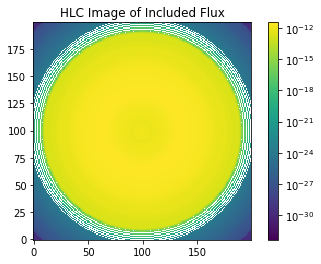

In [17]:
plt.imshow(im,norm=LogNorm())#1e-20,1e-15))
plt.colorbar()
plt.title("HLC Image of Included Flux")
plt.show()

In [17]:
from webbpsf import wfirst
import importlib
importlib.reload(wfirst)

ifs_spc = wfirst.CGI(pixelscale=out_pixscale)
ifs_spc.mode = 'DISKSPC_F721'#CHARSPC_F770' #
#ifs_spc.cgi_family = "DISKSPC"

ifs_spc.cgi_family = "CHARSPC"

FOV=2*1.64

#example cube 
input_fname = my_home_dir + "\zodipics\\" + "zodipic_10pc03mas01alpha.fits"
dust = fits.open(input_fname)

#define adjustable cropping factor
border = 1
input_cube = dust[0].data

dust[0].header["INPUT_FITS"] = input_fname
dust[0].header["PIXELSCL"] = 0.01425
dust[0].header["INPUT_flux"] = "Jy"

#location of center from Ds9 inspection
'''
DS9 coordinate notes, corners are from 0.5-213.5 and center is at 108.
In numpy coordinates the center is at 107,107
'''
center = (107-border)

# find parameters:
dim = input_cube.shape
if len(dim)>2:
    ny = dim[1]
    nx = dim[2]
else:
    ny = dim[0]
    nx = dim[1] 
#test that center is center by removing the flux
#input_cube [0,center,center] =1e-11

NameError: name 'zodi_fits' is not defined

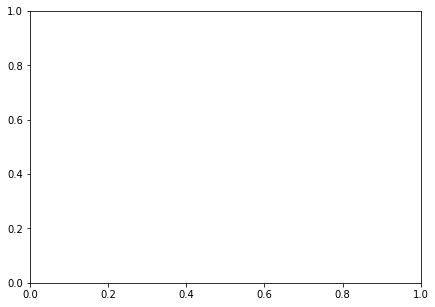

In [18]:
import poppy

plt.figure(figsize=[7,5])

ax = plt.subplot(111)
zodi_r_axis,zodi_ravg = poppy.utils.radial_profile(zodi_fits)
header = fits_header
header['PIXELSCL'] = header['PIX_AS']

r_axis,ravg = poppy.utils.radial_profile(fits.HDUList([fits.ImageHDU(im,header)]))

ax.plot(zodi_r_axis/1000,zodi_ravg/zodi_ravg.max(),'-.',label="Input")

ax.plot([lambda_D.decompose()*206265*3,lambda_D.decompose()*206265*3],[1e-12, 1],'--',color="orange")
ax.text(lambda_D.decompose()*206265*2.2,.85,"IWA",color="orange")

ax.plot(r_axis,ravg/ravg.max(),label="HLC output")
ax.set_ylim([.1,1])
ax.set_xlim([.1,.5])

plt.xlabel("$\prime\prime$")
plt.ylabel("Normalized flux")
plt.legend()
plt.show()

# Model_Annulus\annulus_inc60_r0.4.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc60_r0.4.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Annulus\annulus_inc60_r0.4_HLC.fits
Thresh = 5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


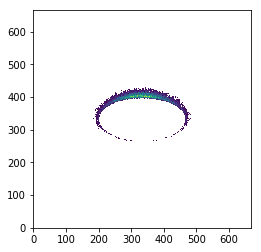

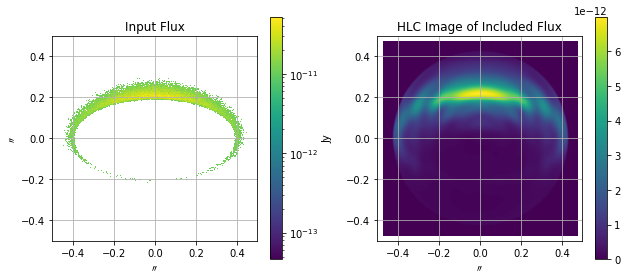

179.32991933822632


In [66]:
reload(disk_processing)

fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"

start_time = time.time()

im,zodi,outfits = disk_processing.disk_through_hlc(fitsfile,
                                                   my_interpolating_function,
                                                   xmas,
                                                   HLC_plate_scale_AS,
                                                   thresh=5,
                                                   display=True)

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc60_r0.4.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Annulus\annulus_inc60_r0.4_HLC.fits
Thresh = 5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


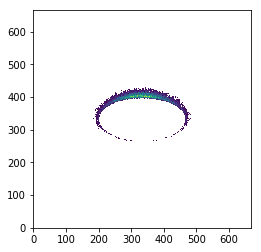

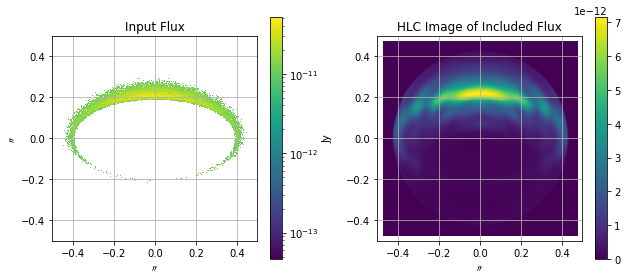

78.2171220779419


In [38]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.5,y_extent = 0.5,
                                   load_existing=False)

end_time = time.time()
print(end_time-start_time)

fitsfile_parts = fitsfile.split("\\")
outfits = my_home_dir + "\KianDebesModels\\" + fitsfile_parts[7] + "\\" + fitsfile_parts[8][:-5] + '_HLC_nearest.fits'
fits.writeto(outfits, im, overwrite = True)


3.4209829406472723e-13
Max location in difference array is [165],[130]
[3.45115113e-12]
Percentage the original at the max differnce location is [9.91258513]%


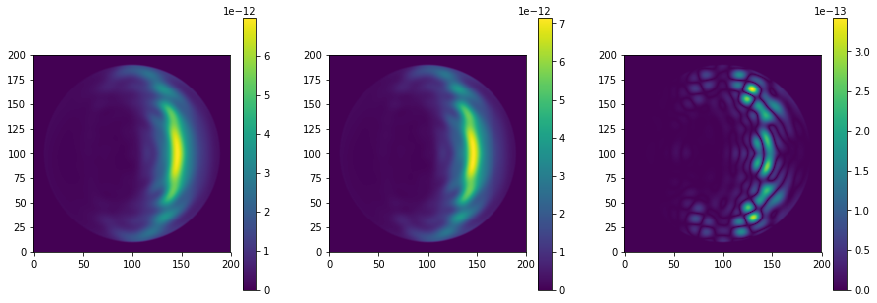

In [48]:
outfits = my_home_dir + "\KianDebesModels\\" + fitsfile_parts[7] + "\\" + fitsfile_parts[8][:-5] + '_HLC.fits'
outfits_n = my_home_dir + "\KianDebesModels\\" + fitsfile_parts[7] + "\\" + fitsfile_parts[8][:-5] + '_HLC_nearest.fits'

im = fits.getdata(outfits)
im_n = fits.getdata(outfits_n)

diff = np.abs(im - im_n)

print(diff.max())

max_loc = np.where(diff == diff.max())
print("Max location in difference array is {},{}".format(max_loc[0],max_loc[1]))
print(im[max_loc[0],max_loc[1]])
print("Percentage the original at the max differnce location is {}%".format(100*diff.max()/im[max_loc[0],max_loc[1]]))

plt.figure(figsize = [15,5])
plt.subplot(131)
plt.imshow(im)
plt.colorbar()

plt.subplot(132)
plt.imshow(im_n)
plt.colorbar()

plt.subplot(133)
plt.imshow(diff)
plt.colorbar()



# Model_Annulus\annulus_inc89_r0.1.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc89_r0.1.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Annulus\annulus_inc89_r0.1_HLC.fits
50000
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


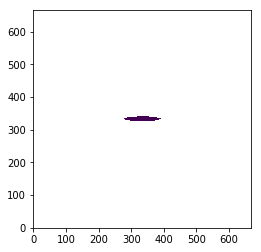

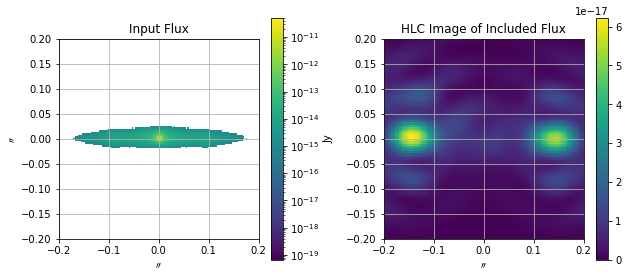

44.074108362197876


In [37]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc89_r0.1.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.2,y_extent = 0.2,
                                   load_existing=False)

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


# Model_ConstantTau\constanttau_inc0_r0.2.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_ConstantTau\constanttau_inc0_r0.2.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_ConstantTau\constanttau_inc0_r0.2_HLC.fits
5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


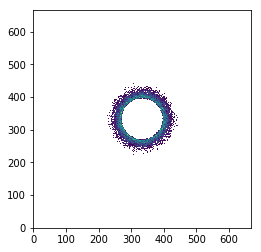

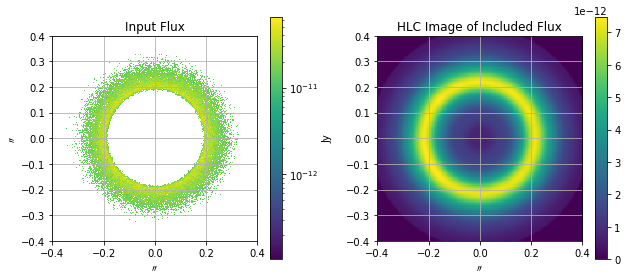

551.1945097446442


In [38]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_ConstantTau\\" + "constanttau_inc0_r0.2.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.4,y_extent = 0.4,
                                   load_existing=False)

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


# Model_Ring\ring_inc0_r0.5.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Ring\ring_inc0_r0.5.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Ring\ring_inc0_r0.5_HLC.fits
5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


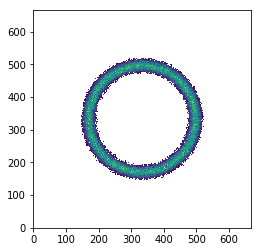

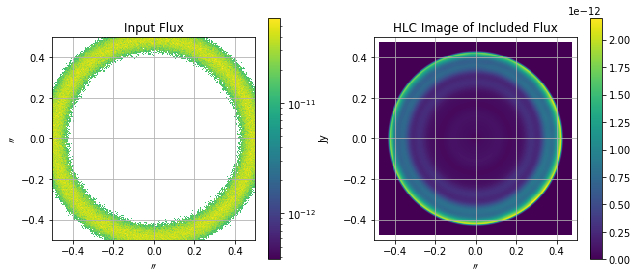

1368.3840646743774


In [39]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_Ring\\" + "ring_inc0_r0.5.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.5,y_extent = 0.5,
                                   load_existing=False)

plt.show()

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


# Model_GAP\gap_inc45_r0.2.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_GAP\gap_inc45_r0.2.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_GAP\gap_inc45_r0.2_HLC.fits
5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


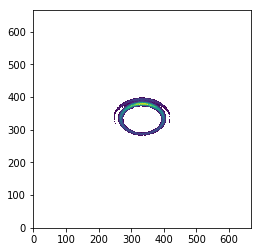

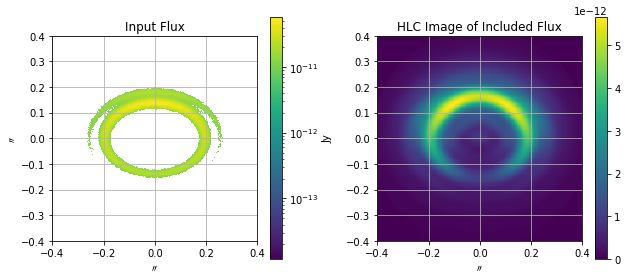

223.67137360572815


In [40]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_GAP\\" + "gap_inc45_r0.2.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.4,y_extent = 0.4,
                                   load_existing=False)

plt.show()

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


# Now just run all the Debes Models

In [ ]:
# Separate the files into the annulus, constanttau, gap, and ring files
dmodels_A = list()
dmodels_C = list()
dmodels_G = list()
dmodels_R = list()

for i,model in enumerate(dmodels):
    if "Annulus" in model: 
        dmodels_A.append(model)
    if "ConstantTau" in model: 
        dmodels_C.append(model)
    if "GAP" in model: 
        dmodels_G.append(model)
    if "Ring" in model: 
        dmodels_R.append(model)

dmodels_G

In [ ]:
dmodels_A_inc0 = list()
dmodels_A_inc30 = list()
dmodels_A_inc45 = list()
dmodels_A_inc60 = list()
dmodels_A_inc89 = list()

for i,model in enumerate(dmodels_A):
    if "inc0" in model:
        dmodels_A_inc0.append(model)
    if "inc30" in model:
        dmodels_A_inc30.append(model)
    if "inc45" in model:
        dmodels_A_inc45.append(model)
    if "inc60" in model:
        dmodels_A_inc60.append(model)
    if "inc89" in model:
        dmodels_A_inc89.append(model)

dmodels_A_inc30

In [ ]:
dmodels_C_inc0 = list()
dmodels_C_inc30 = list()
dmodels_C_inc45 = list()
dmodels_C_inc60 = list()
dmodels_C_inc89 = list()

for i,model in enumerate(dmodels_C):
    if "inc0" in model:
        dmodels_C_inc0.append(model)
    if "inc30" in model:
        dmodels_C_inc30.append(model)
    if "inc45" in model:
        dmodels_C_inc45.append(model)
    if "inc60" in model:
        dmodels_C_inc60.append(model)
    if "inc89" in model:
        dmodels_C_inc89.append(model)

dmodels_C_inc30

In [ ]:
dmodels_R_inc0 = list()
dmodels_R_inc30 = list()
dmodels_R_inc45 = list()
dmodels_R_inc60 = list()
dmodels_R_inc89 = list()

for i,model in enumerate(dmodels_R):
    if "inc0" in model:
        dmodels_R_inc0.append(model)
    if "inc30" in model:
        dmodels_R_inc30.append(model)
    if "inc45" in model:
        dmodels_R_inc45.append(model)
    if "inc60" in model:
        dmodels_R_inc60.append(model)
    if "inc89" in model:
        dmodels_R_inc89.append(model)

dmodels_R_inc30

In [46]:
def process_file(model):
    
    print(model)
    
    zodi_r_axis,zodi_ravg = poppy.utils.radial_profile(model)
    
    try:    
        if model.find("zodipic") == 0:
            thresh=2500
            zoomf = 1
            zodi_r_axis = zodi_r_axis/1000
        else:
            thresh=1/im.min()
            zoomf=2
        
        plt.figure(figsize=[9,4])

        im,zodi_fits,outfile = disk_through_hlc(model,
                                                thresh=thresh,
                                                display=True,
                                                load_existing=False,
                                                #y_extent=float(model[-8:-5])*zoomf,
                                                #x_extent=float(model[-8:-5])*zoomf,
                                                localzodi=localzodi)
        
        out_HDU = fits.HDUList([fits.PrimaryHDU([im])])
        out_HDU[0].header = zodifits.header
        out_HDU[0].header["LOCALZODI"]=localzodi
        out_HDU[0].header["PIXELSCL"]=HLC_plate_scale.value
        
        if localzodi == 0:
            file = model.split("\\")[-1][:-5]+'_HLC.fits'
            path = model.split("\\")[-1][:-5]+'_HLC.fits'
        else:
            file = model.split("\\")[-1][:-5]+'_localHLC.fits'
            path = model.split("\\")[-1][:-5]+'_localHLC.fits'
        
        out_HDU.write(outfits,overwrite=True)
        plt.savefig(model[:-5]+'_HLC.png')
        plt.figure(figsize=[4,3])
        ax=plt.subplot(111)#,aspect='equal')
        #ax.set_aspect(1)

        r_axis,ravg=poppy.utils.radial_profile(fits.HDUList([fits.ImageHDU(im,header=HLC_header)]))

        ax.plot(zodi_r_axis,zodi_ravg/np.nanmax(zodi_ravg),'-.',label="Input")

        ax.plot([lambda_D.decompose()*206265*3,lambda_D.decompose()*206265*3],[1e-12, 1],'--',color="orange")
        ax.text(lambda_D.decompose()*206265*2.2,.85,"IWA",color="orange")

        ax.plot(r_axis,ravg/ravg.max(),label="HLC output")
        ax.set_ylim([.1,1])
        ax.set_xlim([-.05,.5])

        #plt.yscale("log")
        plt.xlabel("$\prime\prime$")
        plt.ylabel("Normalized flux")
        plt.legend()
        plt.savefig(model[:-5]+'_HLC_curve.png', bbox_inches="tight")
        plt.close()

    except Exception as err:
        traceback.print_last()
        #traceback.print_tb(err.__traceback__)

In [44]:
process_file('localzodi.fits')
plt.show()

localzodi.fits


Traceback (most recent call last):
  File "C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-09c4f97de911>", line 3, in <module>
    ifs_spc.autoselect_mode(wavelengths[0])
NameError: name 'ifs_spc' is not defined


In [51]:
model = my_home_dir + "\KianDebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"

print(file)
process_file(model)
plt.show()

annulus_inc60_r0.4_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Annulus\annulus_inc60_r0.4.fits


Traceback (most recent call last):
  File "C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-6ad981f29e1a>", line 2, in <module>
    processfile(model)
NameError: name 'processfile' is not defined


200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025


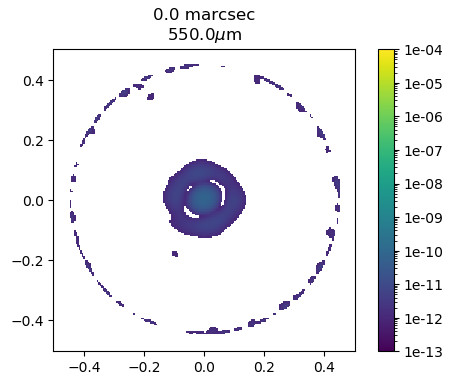

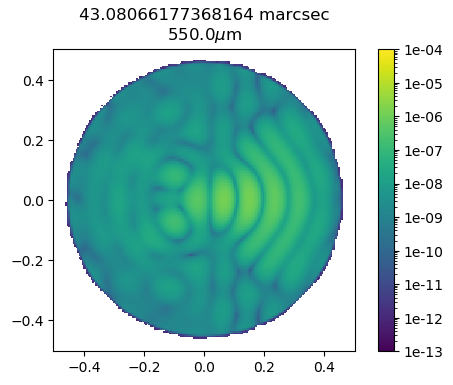

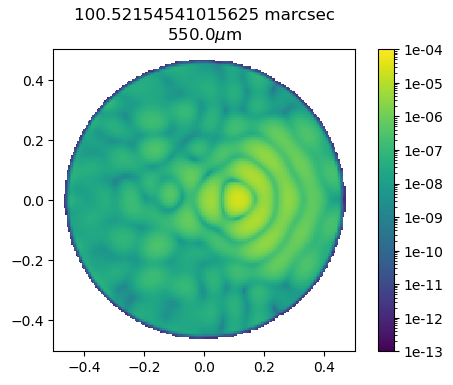

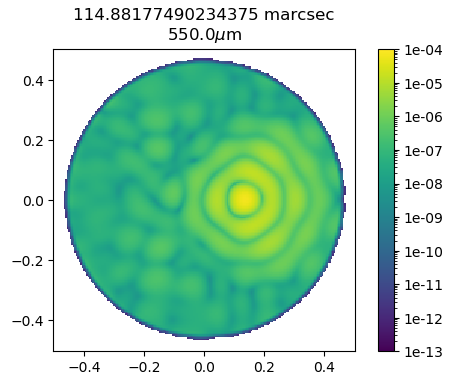

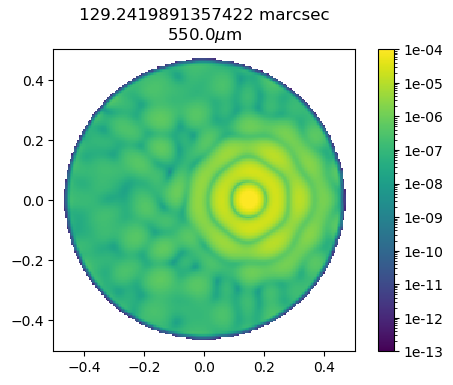

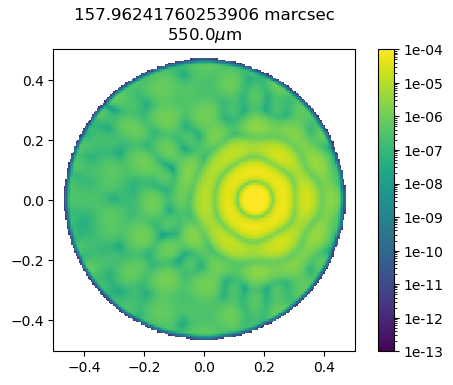

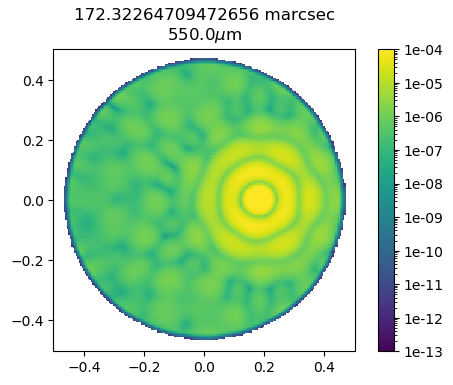

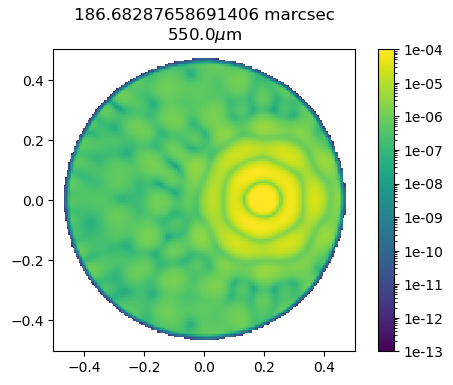

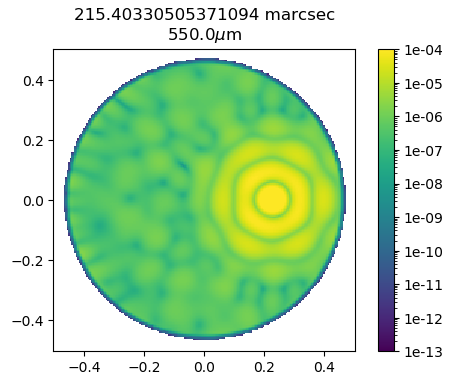

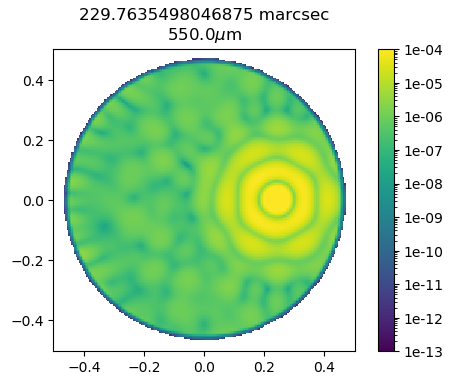

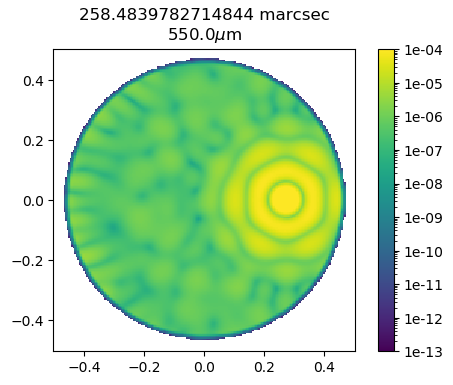

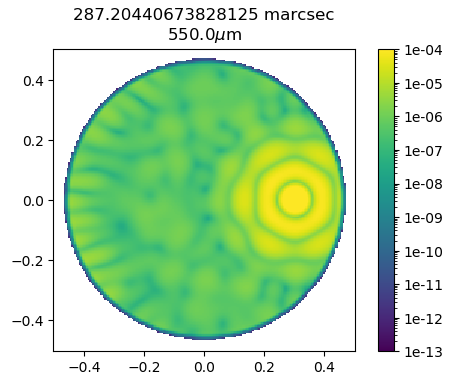

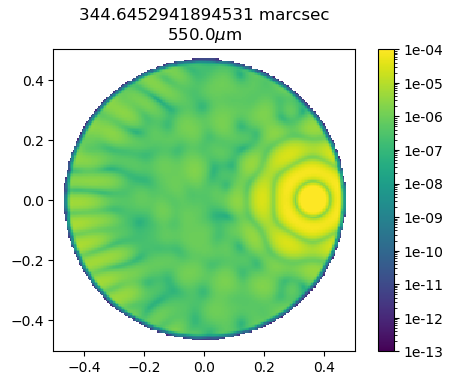

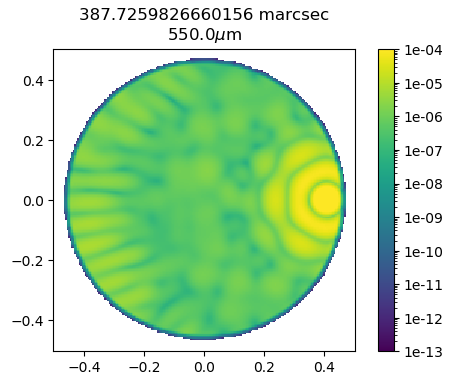

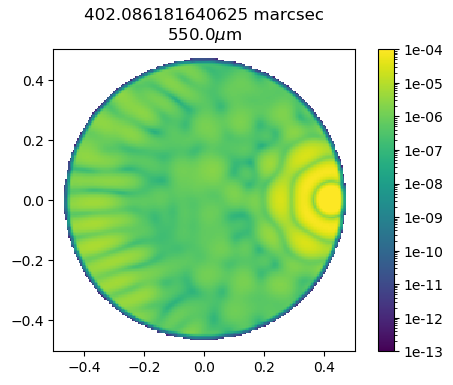

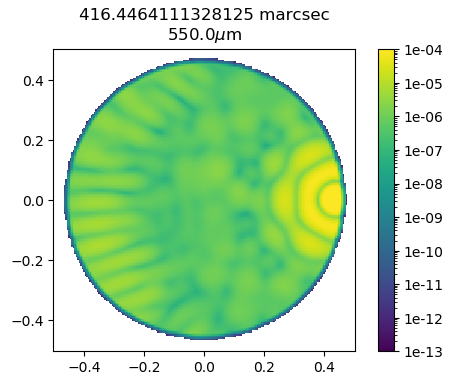

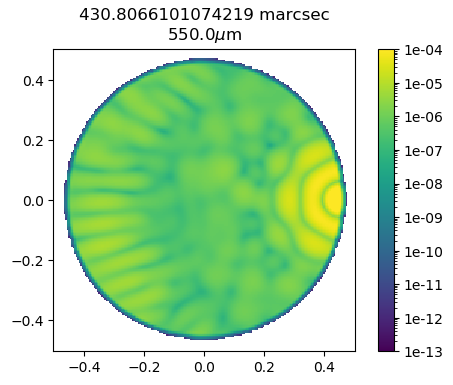

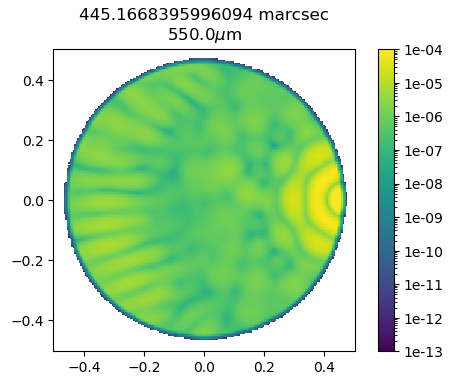

In [11]:
hlcpsfs[hlcpsfs[:,:,:]<1e-12] = 0

for i,angle in enumerate(xmas):
    plt.figure(dpi=100)
    
    displ_scale(hlcpsfs[:,:,i], ps=5*u.milliarcsecond, norm=LogNorm(vmax=1e-4,vmin=1e-13))
    
    plt.title(str(angle)+"\n"+str(fits_header["LAM_C"])+"$\mu$m")
    plt.savefig("PSFanimation\\" + str(angle)[:3] + "mas_PSF.png")
    os.system('cls')


In [12]:
# %%bash
# convert -quality 100% -delay 10 -loop 0 $(ls \PSFanimation\*mas_PSF.png | sort -n)  HLC_animation.mpg